## 1. Calculate the gene expression score

In [ ]:
import os,gc
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np

os.chdir("/data/wuqinhua/scPhase/Lung")

adata = sc.read('./ensemble_adata_with_attention.h5ad')
print("read_over")

adata1 = adata[adata.obs['phenotype'] == "normal"]
adata2 = adata[adata.obs['phenotype'] == "lung adenocarcinoma"]
adata3 = adata[adata.obs['phenotype'] == "squamous cell lung carcinoma"]
print("split_over")

H_gene = pd.read_csv("./ensemble_gene_attributions_normal.csv") 
H_top_200 = H_gene.sort_values(by='mean_attribution', ascending=False).head(200)['gene'].tolist()
H_bottom_200 = H_gene.sort_values(by='mean_attribution', ascending=True).head(200)['gene'].tolist()
sc.tl.score_genes(adata1, H_top_200, score_name='gene_ex_score_top')
sc.tl.score_genes(adata1, H_bottom_200, score_name='gene_ex_score_bottom')
adata1.obs.to_csv('./Analysis/Figure/gene_ex_scores_normal_top_bottom_200.csv')
print("Phenotype Not_AD scores saved.")

M_gene = pd.read_csv("./ensemble_gene_attributions_lung_adenocarcinoma.csv") 
M_top_200 = M_gene.sort_values(by='mean_attribution', ascending=False).head(200)['gene'].tolist()
M_bottom_200 = M_gene.sort_values(by='mean_attribution', ascending=True).head(200)['gene'].tolist()
sc.tl.score_genes(adata2, M_top_200, score_name='gene_ex_score_top')
sc.tl.score_genes(adata2, M_bottom_200, score_name='gene_ex_score_bottom')
adata2.obs.to_csv('./Analysis/Figure/gene_ex_scores_LUAD_top_bottom_200.csv')
print("Phenotype Low scores saved.")

S_gene = pd.read_csv("./ensemble_gene_attributions_squamous_cell_lung_carcinoma.csv") 
S_top_200 = S_gene.sort_values(by='mean_attribution', ascending=False).head(200)['gene'].tolist()
S_bottom_200 = S_gene.sort_values(by='mean_attribution', ascending=True).head(200)['gene'].tolist()
sc.tl.score_genes(adata3, S_top_200, score_name='gene_ex_score_top')
sc.tl.score_genes(adata3, S_bottom_200, score_name='gene_ex_score_bottom')
adata3.obs.to_csv('./Analysis/Figure/gene_ex_scores_LUSC_top_bottom_200.csv')
print("Phenotype Intermediate scores saved.")

print("\nAll processing complete.")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: 

read_over
split_over


/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


Phenotype Not_AD scores saved.


/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


Phenotype Low scores saved.


/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


Phenotype Intermediate scores saved.

All processing complete.


In [2]:
library(dplyr)
library(tidyr)
library(reshape2)
library(ggplot2)
library(ggrepel)
library(scales)
setwd("/data/wuqinhua/scPhase/Lung")

attnData <- read.csv('./Lung_metadata.csv')
sampleInfo = read.csv('./sample_info.csv')

nameAll = unique(attnData$celltype)
nameAll = sort(nameAll)
nameAll

nameList = nameAll

sampleFold = data.frame(id = character(), celltype = character(), fold = numeric())
idList = unique(attnData$sample_id)
for (id in idList) {
  attnTmp = attnData %>% filter(sample_id == id)
  avgScore = 1 / dim(attnTmp)[1]
  foldRes = attnTmp %>% group_by(celltype) %>% summarise(res = median(log2(attention_weight_mean/avgScore)))
  dataTmp = data.frame(id = rep(id,dim(foldRes)[1]),
                       celltype = foldRes$celltype,
                       fold = foldRes$res)
  dataTmp_s = dataTmp %>% filter(celltype %in% nameList)
  dataTmp_s$fold = scale(dataTmp_s$fold)
  sampleFold = rbind(sampleFold,dataTmp_s)
}

sampleFold.Table <- dcast(sampleFold, id ~ celltype)
rownames(sampleFold.Table) <- sampleFold.Table$id
sampleFold.Table$id <- NULL
attn <- sampleFold.Table

ex_H <- read.csv('./Analysis/Figure/gene_ex_scores_normal_top_bottom_200.csv')
ex_M <- read.csv('./Analysis/Figure/gene_ex_scores_LUAD_top_bottom_200.csv')
ex_S <- read.csv("./Analysis/Figure/gene_ex_scores_LUSC_top_bottom_200.csv")

exData <- rbind(ex_H, ex_M, ex_S)

process_expression_data <- function(exData, sample_id_col, gene_ex_score_col) {
  nameAll <- unique(exData$celltype)
  nameList <- sort(nameAll)
  
  sampleFold <- data.frame(id = character(), celltype = character(), fold = numeric())
  idList <- unique(exData[[sample_id_col]])
  
  for (id in idList) {
    attnTmp <- exData %>% filter(.data[[sample_id_col]] == id)
    foldRes <- attnTmp %>% group_by(celltype) %>% summarise(res = median(.data[[gene_ex_score_col]]))
    dataTmp <- data.frame(id = rep(id, dim(foldRes)[1]),
                         celltype = foldRes$celltype,
                         fold = foldRes$res)
    dataTmp_s <- dataTmp %>% filter(celltype %in% nameList)
    sampleFold <- rbind(sampleFold, dataTmp_s)
  }
  
  ex_sampleFold.Table <- dcast(sampleFold, id ~ celltype)
  rownames(ex_sampleFold.Table) <- ex_sampleFold.Table$id
  ex_sampleFold.Table$id <- NULL
  return(ex_sampleFold.Table)
}

ex_top <- process_expression_data(exData, 'sample_id', 'gene_ex_score_top')
ex_bottom <- process_expression_data(exData, 'sample_id', 'gene_ex_score_bottom')
sampleInfo <- sampleInfo[rownames(attn), ]
ex_top <- ex_top[rownames(attn), colnames(attn)]
ex_bottom <- ex_bottom[rownames(attn), colnames(attn)]

ex_diff <- ex_top - ex_bottom

custom_colors <- c("normal" = "#A2D8A2", "lung adenocarcinoma" = "#B8D8F1", "squamous cell lung carcinoma" = "#F5B54F")

sampleInfo = read.csv('./sample_info.csv')

attn_long <- attn %>%
  tibble::rownames_to_column("sample") %>%
  pivot_longer(cols = -sample, names_to = "cell_type", values_to = "attn_value")

ex_diff_long <- ex_diff %>%
  tibble::rownames_to_column("sample") %>%
  pivot_longer(cols = -sample, names_to = "cell_type", values_to = "ex_diff_value")

plot_data_long <- attn_long %>%
  left_join(ex_diff_long, by = c("sample", "cell_type")) %>%
  left_join(sampleInfo %>% select(sample, disease), by = c("sample" = "sample")) %>%
  mutate(group = factor(disease, levels = names(custom_colors))) %>%
  na.omit()

[1] "Alveolar cell type 1"            "Alveolar cell type 2"           
 [3] "B cell"                          "B cell dividing"                
 [5] "Cancer cells"                    "cDC1"                           
 [7] "cDC2"                            "Ciliated"                       
 [9] "Club"                            "DC mature"                      
[11] "Endothelial cell arterial"       "Endothelial cell capillary"     
[13] "Endothelial cell lymphatic"      "Endothelial cell venous"        
[15] "Fibroblast adventitial"          "Fibroblast alveolar"            
[17] "Fibroblast peribronchial"        "Macrophage"                     
[19] "Macrophage alveolar"             "Mast cell"                      
[21] "Mesothelial"                     "Monocyte classical"             
[23] "Monocyte non-classical"          "Myeloid dividing"               
[25] "Neutrophils"                     "NK cell"                        
[27] "NK cell dividing"                "pDC"                            
[29] "Pericyte"                        "Plasma cell"                    
[31] "Plasma cell dividing"            "ROS1+ healthy epithelial"       
[33] "Smooth muscle cell"              "Stromal dividing"               
[35] "T cell CD4"                      "T cell CD4 dividing"            
[37] "T cell CD8 activated"            "T cell CD8 dividing"            
[39] "T cell CD8 effector memory"      "T cell CD8 naive"               
[41] "T cell CD8 terminally exhausted" "T cell NK-like"                 
[43] "T cell regulatory"               "Transitional Club/AT2"

Using fold as value column: use value.var to override.

Using fold as value column: use value.var to override.

Using fold as value column: use value.var to override.



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


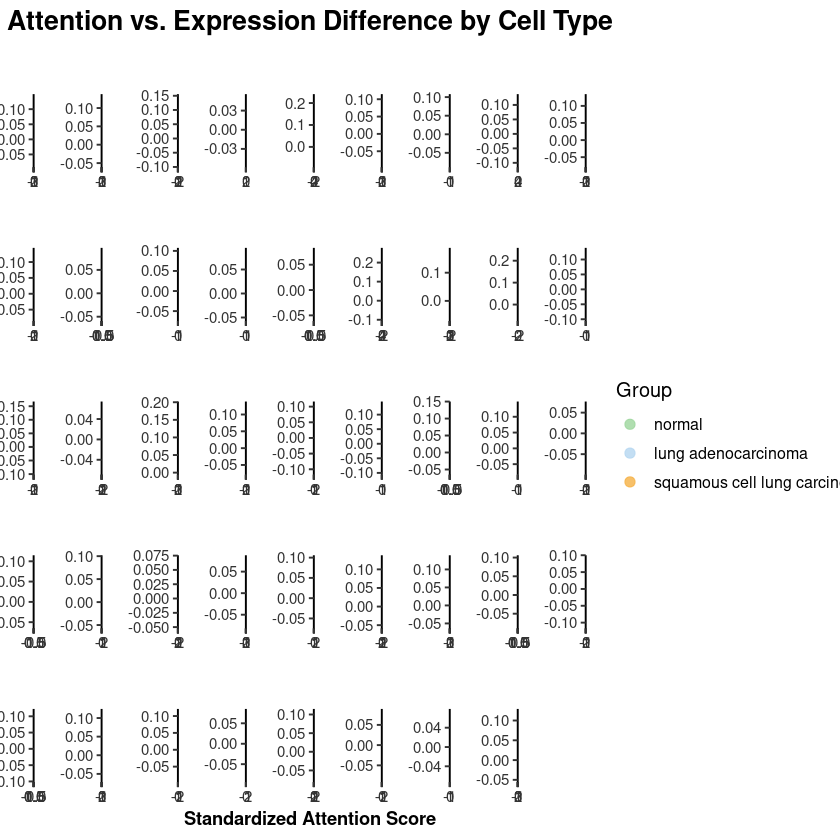

In [3]:
annotation_data <- plot_data_long %>%
  group_by(cell_type) %>%
  summarise(
    cor_test_res = list(cor.test(attn_value, ex_diff_value, method = "pearson")),
    pcc_value = cor_test_res[[1]]$estimate,
    p_value = cor_test_res[[1]]$p.value
  ) %>%
  mutate(
    significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01  ~ "**",
      p_value < 0.05  ~ "*",
      TRUE ~ ""
    ),
    title_with_sig = paste0(cell_type, " ", significance),
    label_string = paste0("PCC = ", round(pcc_value, 3), 
                          ", ", 
                          scales::pvalue(p_value, accuracy = 0.001, add_p = TRUE))
  )

plot_data_final <- plot_data_long %>%
  left_join(annotation_data %>% select(cell_type, title_with_sig), by = "cell_type")

final_plot <- ggplot(plot_data_final, aes(x = attn_value, y = ex_diff_value)) +
  
  geom_point(aes(color = group), alpha = 0.85, size = 2.5) +
  
  geom_smooth(
    method = "lm", se = TRUE,
    color = "#666666", fill = "#C9C9C9",
    alpha = 0.25, linewidth = 1
  ) +

  geom_text(
    data = annotation_data, 
    aes(label = label_string),
    x = -Inf, y = Inf,     
    hjust = -0.1, vjust = 1.5, 
    size = 3
  ) +
  
  scale_color_manual(values = custom_colors, name = "Group") +

  facet_wrap(~title_with_sig, scales = "free",nrow = 5, ncol = 9) +
  
  labs(
    title = "Attention vs. Expression Difference by Cell Type",
    x = "Standardized Attention Score",
    y = "Expression Score Difference (Top - Bottom)"
  ) +
  
  theme_classic(base_size = 12) +
  theme(
    panel.background = element_rect(fill = "white", color = NA),
    plot.background  = element_rect(fill = "white", color = NA),
    # panel.grid.major = element_line(color = "grey92", linewidth = 0.5),
    strip.background = element_rect(fill = "#EFEFEF", color = NA),
    strip.text = element_text(size = 10, face = "bold", color = "#333333"),
    axis.text = element_text(size = 9, color = "#333333"),
    axis.title = element_text(size = 11, face = "bold"),
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold", margin = ggplot2::margin(b = 15)),
    panel.spacing = unit(1, "lines")
  )

ggsave("./Analysis/Figure/Con_plot/correlation_faceted_plot.pdf",
       final_plot, width = 30, height = 15, dpi = 300)

print(final_plot)